Implementation of Tipping, Michael E. (2001). _Sparse Bayesian Learning and the Relevance Vector Machine_. Journal of Machine Learning Research. 1: 211–244

# Regression

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

First, let's generate some data, following the example in section 3.1

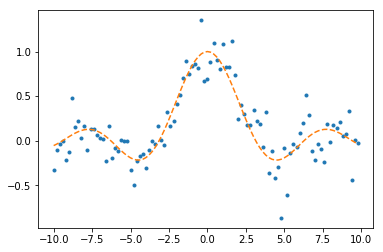

In [2]:
def generate_training_data(count, xmin, xmax, sigma2):
    xx = np.arange(xmin, xmax, (xmax - xmin) / count)
    ee = np.random.normal(scale=sigma2, size=count)
    
    return xx, np.sin(abs(xx)) / abs(xx) + ee

tx, ty = generate_training_data(100, -10, 10, 0)
data_xs, data_ys = generate_training_data(100, -10, 10, 0.2)

plt.plot(data_xs, data_ys, '.')
plt.plot(tx, ty, '--')
plt.show()

And define the kernel we will use for this little example

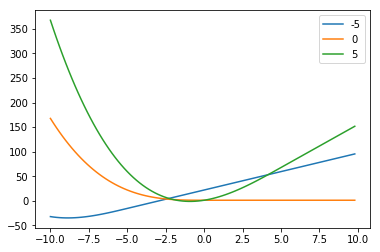

In [3]:
def linear_spline_kernel(xi, xj):
    sm = np.minimum(xi, xj)
    return (
        1 +
        xi * xj +
        xi * xj * sm -
        (xi + xj) * sm**2 / 2+
        sm**3 / 3
    )


for x0 in [-5, 0, 5]:
    xs = np.arange(-10, 10, 20 / 100)
    kk = linear_spline_kernel(np.array([x0] * 100), xs)
    plt.plot(xs, kk, label=str(x0))

plt.legend(loc='upper right')
plt.show()

We can now compute the design matrix $\Phi$, with $\Phi_{nm}=K(x_n, x_{m-1})$ and $\Phi_{n1}=1$

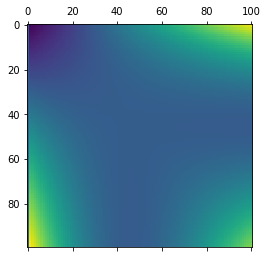

In [4]:
def compute_design_matrix(data_x, kernel):
    phi = np.ones((data_x.shape[0], data_x.shape[0] + 1))
    for n, xx in enumerate(data_x):
        phi[n, 1:] = kernel(xx, data_x)
    return phi


plt.matshow(compute_design_matrix(data_xs, linear_spline_kernel))
plt.show()

And, finally, the iterative algorithm to find the RVM parameters for regression:

In [5]:
def compute_rvm_params_reg(data_x, data_y, kernel, max_iter=10000,
                           min_log_evidence_increase=1e-9):

    N = data_x.shape[0]
    if len(data_y.shape) < 2:  # reshape to a column vector
        data_y = data_y.reshape((-1, 1))

    assert data_x.shape[0] == data_y.shape[0], \
        'x and y have a different number of samples'

    phi = compute_design_matrix(data_x, kernel)
    alphas = np.random.random(size=(N + 1, 1)) + 1e-10
    sigma2 = np.random.random() + 1e-10

    aaas = np.zeros((max_iter, alphas.shape[0]))
    evidences = []
    
    for i in range(max_iter):
        A = np.diag(alphas.reshape(-1))
        B = np.eye(N) / sigma2

        # compute posterior parameters using (5) and (6)
        cov = np.linalg.inv(phi.T.dot(B).dot(phi) + A)
        mu = cov.dot(phi.T).dot(B).dot(data_y)

        # compute new alphas using (8)
        gammas = 1 - alphas * np.diag(cov).reshape((-1, 1))
        alphas = gammas / mu**2
        alphas[alphas > 1e9] = 1e9 + 1  # prevent alphas from exploding
        
        # compute new sigma using (10)
        sigma2 = np.sum((data_y - phi.dot(mu))**2) / (N - gammas.sum())
        
        # compute evidence using (7) and check for stopping criterion
        ainv = np.diag(1 / alphas.reshape(-1))
        binv = sigma2 * np.eye(N)
        evidence_cov = binv + phi.dot(ainv).dot(phi.T)
        new_evidence = multivariate_normal.logpdf(data_y.reshape(-1), cov=evidence_cov)
        if i > 0 and new_evidence - evidences[-1] < min_log_evidence_increase:
            break

        evidences.append(new_evidence)
        aaas[i] = alphas.reshape(-1)
    
    return mu, cov, sigma2, aaas[:i], evidences

mu, cov, sigma2, all_alphas, evidences = compute_rvm_params_reg(data_xs, data_ys, linear_spline_kernel)

In [6]:
print('Using %d relevance vectors, estimated variance is %f' % (
    np.sum(all_alphas[-1] < 1e9) - 1, np.sqrt(sigma2)
))

Using 7 relevance vectors, estimated variance is 0.195892


This is how the $\alpha$'s changed during fitting:

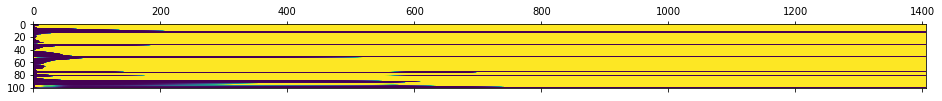

In [7]:
plt.matshow(all_alphas.T)

And this is the increase in evidence:

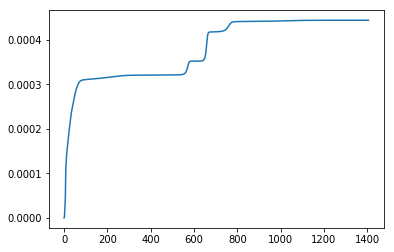

In [8]:
plt.plot(np.exp(evidences))

Finally, let's sample some weights from the posterior and  plot functions fitted using only the relevance vectors:

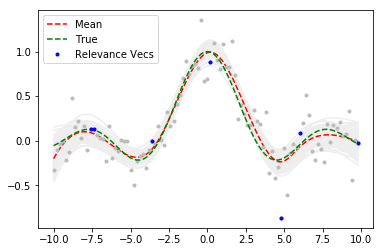

In [9]:
rv = np.argwhere(all_alphas[-1] < 1e9)[1:] - 1
num_samples = 100
for i in range(num_samples):
    if i < num_samples - 1:
        weights = np.random.multivariate_normal(mu.reshape(-1), cov)
    else:
        weights = mu.reshape(-1)

    pys, fill_low, fill_high = [], [], []

    for xx in tx:
        ker = linear_spline_kernel(xx, data_xs[rv])
        yy = weights[0] + np.sum(weights[rv + 1] * ker)
        pys.append(yy)

    if i < num_samples - 1:
        plt.plot(tx, pys, c='#eeeeee')
    else:
        plt.plot(tx, pys, 'r--', label='Mean')

plt.plot(data_xs, data_ys, '.', c='#bbbbbb')
plt.plot(tx, ty, 'g--', label='True')
plt.plot(data_xs[rv], data_ys[rv], 'b.', label='Relevance Vecs')
plt.legend(loc='upper left')
plt.show()

Here is an utility function for your convenience; it returns the indices of the data points to use as relevance vectors, and the corresponding weights. An index of -1 means that the prediction uses the bias, which is then the first weight.

In [11]:
def rvm_regression_fit(data_x, data_y, kernel, **kwargs):
    mu, cov, sigma2, all_alphas, evidences = compute_rvm_params_reg(data_x, data_y, kernel, **kwargs)
    rv = np.argwhere(all_alphas[-1] < 1e9).reshape(-1)
    return rv - 1, mu.reshape(-1)[rv]

rvm_regression_fit(data_xs, data_ys, linear_spline_kernel)

(array([-1, 18, 19, 28, 49, 72, 86, 87, 99], dtype=int64),
 array([ -7.49270735e-01,   1.47964375e-01,   2.30746240e-06,
         -3.32829829e-01,   2.87007909e-01,  -3.00078880e-01,
          1.55127412e-06,   2.51826982e-01,  -8.65575959e-02]))

# Classification

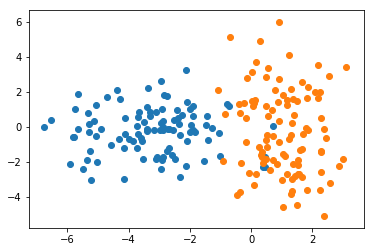

In [2]:
def generate_training_data(count_pos, mus_pos, covs_pos, count_neg, mus_neg, covs_neg):
    xs, ys = [], []
    for i in range(count_pos):
        g = np.random.choice(len(mus_pos))
        mu, cov = mus_pos[g], covs_pos[g]
        xx = np.random.multivariate_normal(mu, cov)
        xs.append(xx)
        ys.append(1)
        
    for i in range(count_neg):
        g = np.random.choice(len(mus_neg))
        mu, cov = mus_neg[g], covs_neg[g]
        xx = np.random.multivariate_normal(mu, cov)
        xs.append(xx)
        ys.append(0)

    return np.array(xs), np.array(ys)

data_xs, data_ys = generate_training_data(
    100, [[1, 2], [1, -2]], [np.diag([1, 2]), np.diag([1, 2])],
    100, [[-3, 0]], [np.diag([2, 2])],
)

plt.scatter(data_xs[data_ys == 0, 0], data_xs[data_ys == 0, 1])
plt.scatter(data_xs[data_ys == 1, 0], data_xs[data_ys == 1, 1])
plt.show()

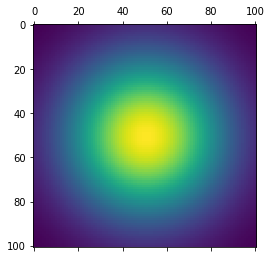

In [3]:
def gaussian_kernel(sigma2):
    def compute(xa, xb):
        return np.exp(-np.sum((xa - xb)**2, axis=1) / (2 * sigma2))
    return compute


ker = gaussian_kernel(0.25)
cnt = 101
mat = np.zeros((cnt, cnt))
for i, yy in enumerate(np.arange(-1, 1, 2 / cnt)):
    xx = np.zeros((cnt, 2))
    tgt = np.zeros((cnt, 2))
    xx[:, 0] = np.arange(-1, 1, 2 / cnt)
    xx[:, 1] = yy
    
    mat[i] = ker(tgt, xx)
    
plt.matshow(mat)
plt.show()

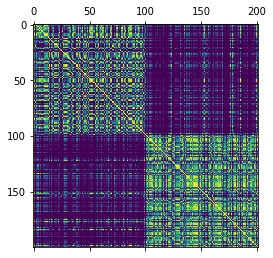

In [4]:
def compute_design_matrix(data_x, kernel):
    phi = np.ones((data_x.shape[0], data_x.shape[0] + 1))
    for n, xx in enumerate(data_x):
        phi[n, 1:] = kernel(xx, data_x)
    return phi


plt.matshow(compute_design_matrix(data_xs, gaussian_kernel(3)))
plt.show()

In [5]:
def compute_posterior_log_probability_and_gradient(data_y, phi, weights, alphas):
    # log pdf of a centered normal w/ diagonal covariance
    # to avoid numerical problems when computing inverse and determinant
    k = weights.shape[0]
    log_prior = -(np.sum(alphas * weights**2) + (
        k * np.log(2 * np.pi) - np.sum(np.log(alphas))
    )) / 2

    y_pred = 1 / (1 + np.exp(-phi.dot(weights)))
    log_prob = np.sum(data_y * np.log(y_pred + 1e-10) + (1 - data_y) * np.log(1 - y_pred + 1e-10))

    log_prior_grad = -2 * weights * alphas
    log_prob_grad = phi.T.dot(data_y - y_pred)

    return log_prob + log_prior, log_prob_grad + log_prior_grad

In [6]:
ALPHA_CUTOFF = 1e9


def maximize_posterior(data_y, phi, alphas, weights, min_improvement=1e-3, max_iter=2000,
                       base_lrate=0.1, momentum=0.1, verbose=False):

    old_gradient, old_likelihood, lrate = None, 0, base_lrate
    for i in range(max_iter):
        weights[alphas > ALPHA_CUTOFF] = 0
        new_likelihood, gradient = compute_posterior_log_probability_and_gradient(
            data_y, phi, weights, alphas
        )
        gradient[alphas > ALPHA_CUTOFF] = 0
        
        # clip gradient
        mag = np.sqrt(np.sum(gradient**2))
        if mag > 1:
            gradient = gradient / mag
        
        # apply momentum
        if old_gradient is not None:
            gradient = momentum * old_gradient + (1 - momentum) * gradient

        # halve learning rate if function decreased
        if new_likelihood < old_likelihood:
            base_lrate *= 0.5
        
        # decay learning rate
        lrate = base_lrate / np.sqrt(i + 1)
        
        # update and check for stopping criterion
        weights += lrate * gradient

        if verbose:
            print(i, old_likelihood, new_likelihood,
                  old_likelihood - new_likelihood,
                  mag, np.sum(gradient**2), lrate)

        if i > 10 and abs(new_likelihood - old_likelihood) < min_improvement:
            break

        old_likelihood, old_gradient = new_likelihood, gradient

    return weights, new_likelihood

In [7]:
def compute_rvm_params_class(data_x, data_y, kernel, min_improvement=-1e-1,
                             max_iter=25000, verbose=False):
    phi = compute_design_matrix(data_x, kernel)
    alphas = np.random.random(size=data_y.shape[0] + 1) + 1e-9

    smooth_wlik, aaas, smooth_liks, liks = 0, [], [], []
    for i in range(max_iter):
        # maximize posterior starting from previous most likely weights
        w0 = wmp if i > 0 else np.zeros(data_y.shape[0] + 1)
        wmp, wlik = maximize_posterior(data_y, phi, alphas, w0)
        
        # compute new parameters
        y_pred = 1 / (1 + np.exp(-phi.dot(wmp)))
        A = np.diag(alphas.reshape(-1))
        B = np.diag(y_pred * (1 - y_pred))
        cov = np.linalg.inv(phi.T.dot(B).dot(phi) + A)

        gammas = 1 - alphas * np.diag(cov)
        alphas = gammas / wmp**2
        alphas[alphas > ALPHA_CUTOFF] = ALPHA_CUTOFF + 1  # prevent alphas from exploding

        # debug and stopping criterion
        alive = np.sum(alphas < ALPHA_CUTOFF)
        smooth_wlik = 0.99 * smooth_wlik + 0.01 * wlik
        if i > 10:
            improvement = abs(smooth_liks[-1] - smooth_liks[-10])
        else:
            improvement = min_improvement + 1
        
        aaas.append(alphas)
        liks.append(wlik)
        smooth_liks.append(smooth_wlik)
        
        if verbose:
            print('=====', i, wlik, alive)
            print(wlik, smooth_wlik,)

        assert alive > 0, 'no relevance vectors'
        if i > 10 and improvement < min_improvement:
            break

    return wmp, cov, aaas, liks


wmp, cov, aaas, liks = compute_rvm_params_class(data_xs, data_ys, gaussian_kernel(3))

C:\Users\edo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


Evolution of the coefficients during training:

<Figure size 1440x360 with 0 Axes>

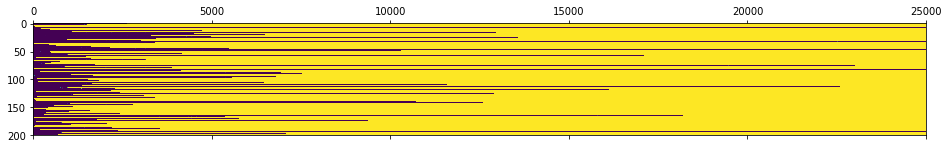

In [8]:
plt.figure(figsize=(20, 5))
plt.matshow(np.array(aaas).T, aspect='auto')

Number of relevance vectors:

In [9]:
np.sum(aaas[-1] < ALPHA_CUTOFF)

6

Evolution of the likelihood during training:

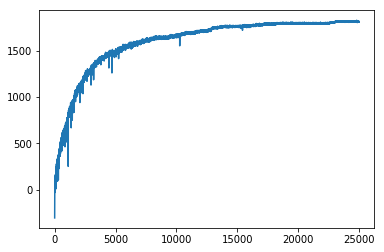

In [10]:
plt.plot(liks)

And here are the predictions, with the decision boundary, probability of belonging to class 1, and relevance vectors:

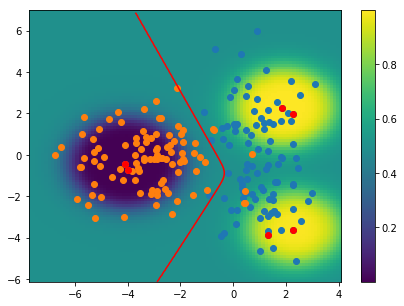

In [17]:
cnt = 101
heatmap = np.zeros((cnt, cnt))
ker = gaussian_kernel(1)

rv = np.argwhere(aaas[-1] < ALPHA_CUTOFF).reshape(-1) - 1
rv_xs = data_xs[rv]
weights = wmp[rv + 1]

limx = np.min(data_xs[:, 0]) - 1, np.max(data_xs[:, 0]) + 1
all_xs = np.arange(limx[0], limx[1], (limx[1] - limx[0]) / cnt)

limy = np.min(data_xs[:, 1]) - 1, np.max(data_xs[:, 1]) + 1
all_ys = np.arange(limy[0], limy[1], (limy[1] - limy[0]) / cnt)

for i, xx in enumerate(all_xs):
    for j, yy in enumerate(all_ys):
        tx = np.array([xx, yy] * (rv_xs.shape[0])).reshape(-1, 2)
        kk = ker(tx, rv_xs)
        cls = 1 / (1 + np.exp(-np.sum(kk * weights)))
        heatmap[j, i] = cls

plt.figure(figsize=(7, 5))
plt.contour(all_xs, all_ys, heatmap, levels=[0.5], colors=['r'])
plt.scatter(data_xs[data_ys == 1, 0], data_xs[data_ys == 1, 1])
plt.scatter(data_xs[data_ys == 0, 0], data_xs[data_ys == 0, 1])
plt.scatter(data_xs[rv, 0], data_xs[rv, 1], c='r')
plt.imshow(heatmap, extent=limx + limy, origin='lower', aspect='auto')
plt.colorbar()
plt.xlim(limx)
plt.ylim(limy)
plt.show()

Finally, an utility function:

In [ ]:
def rvm_classification_fit(data_x, data_y, kernel, **kwargs):
    wmp, cov, all_alphas, likelihoods = compute_rvm_params_class(data_x, data_y, kernel, **kwargs)
    rv = np.argwhere(all_alphas[-1] < ALPHA_CUTOFF).reshape(-1)
    return rv - 1, wmp.reshape(-1)[rv]

rvm_classification_fit(data_xs, data_ys, gaussian_kernel(1))